### Modified Blackjack environment
- Basic implementation from: https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py
- Personal edits for playing until the deck reaches a certain threshold for the number of cards
- Personal edits for Complete Point count system

In [5]:
import os
from typing import Optional

import numpy as np

import gym
from gym import spaces
from gym.error import DependencyNotInstalled

import random


def cmp(a, b):
    return float(a > b) - float(a < b)

def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]

# Custom addition for counting cards
def complete_point_count_system(deck):
  score = 0
  for card in deck:
    if int(card) in [2,3,4,5,6]:
      score += 1
    elif int(card) in [10,1]:
      score -= 1
    else:
      pass
  return score
# Custom addition for counting cards
def count_cards(current_score_counted, cards_seen):
    val_cards_left = current_score_counted + complete_point_count_system(cards_seen)
    return val_cards_left


class BlackjackEnv(gym.Env):
    def __init__(self, render_mode: Optional[str] = None, natural=False, sab=False, counting_cards=False, num_decks=1):
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Tuple(
            (spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(2))
        )

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural

        # Flag for full agreement with the (Sutton and Barto, 2018) definition. Overrides self.natural
        self.sab = sab

        self.render_mode = render_mode

        self.num_decks = num_decks
        self.deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4 * num_decks

        # Score for Complete Point count system
        self.counting_cards = counting_cards
        self.counting_score = 0

    def draw_card(self, np_random):
      if self.counting_cards == True:
        return int(self.deck.pop())
      else:
        return int(np_random.choice(self.deck))


    def draw_hand(self, np_random):
      return [self.draw_card(np_random), self.draw_card(np_random)]

    def step(self, action):
        assert self.action_space.contains(action)
        if action:  # hit: add a card to players hand and return
            self.player.append(self.draw_card(self.np_random))
            if is_bust(self.player):
                terminated = True
                reward = -1.0
            else:
                terminated = False
                reward = 0.0
        else:  # stick: play out the dealers hand, and score
            terminated = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                reward = 1.0
            elif (
                not self.sab
                and self.natural
                and is_natural(self.player)
                and reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                reward = 1.5

        return self._get_obs(), reward, terminated, False, {}

    def _get_obs(self):
        if self.counting_cards == True:
          counting_cards_value = count_cards(self.counting_score, [self.player[0], self.player[1], self.dealer[0]])
          return (sum_hand(self.player), self.dealer[0], usable_ace(self.player), counting_cards_value)
        else:
          return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(
        self,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        if self.counting_cards == True:
          # Only reshuffle when the cards get to less than 16 cards
          if len(self.deck) <= 15:
            super().reset(seed=seed)
            self.deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4 * self.num_decks
            random.shuffle(self.deck)
        else:
            super().reset(seed=seed)

        self.dealer = self.draw_hand(self.np_random)
        self.player = self.draw_hand(self.np_random)

        return self._get_obs()

### Traditional RL-methods Implementations for Sarsa, Q-Learning, Temporal Difference
- From: https://github.com/abken601/Blackjack-Reinforcement-Learning/tree/master

In [6]:
import random

class Strategy:

    def random_action(self):
        if random.random() <= 0.5:
            return 0
        else:
            return 1

    def epsilon_greedy_policy_from_q_table_dict(self, epsilon, q_table_dict, player_card_points, dealer_card_points, player_card_usable_ace):
        # P = epsilon: exploration
        if random.random() < epsilon:
            return self.random_action()
        # P = 1-epsilon: exploitation
        else:
            return self.best_action_policy_from_q_table_dict(q_table_dict, player_card_points, dealer_card_points, player_card_usable_ace)

    def best_action_policy_from_q_table_dict(self, q_table_dict, player_card_points, dealer_card_points, player_card_usable_ace):
        # Q function for state (playerCardPoints, dealerCardPoints, hit)
        hit_value = q_table_dict[(player_card_points, dealer_card_points, player_card_usable_ace, 0)]
        # Q function for state (playerCardPoints, dealerCardPoints, stick)
        stick_value = q_table_dict[(player_card_points, dealer_card_points, player_card_usable_ace, 1)]

        if hit_value > stick_value:
            return 0
        elif stick_value > hit_value:
            return 1
        else:
            return self.random_action()

    def update_q_table_dict(self, reward, occurred_state_actions, q_table_dict, state_count, state_action_count, method, gamma = 0.8):
        # update over all keys
        for i in range(len(occurred_state_actions)):
            state = occurred_state_actions[i][:-1]
            state_action = occurred_state_actions[i]
            # update counts
            state_count[state] += 1
            state_action_count[state_action] += 1

            # set the learning rate
            alpha = 1.0 / state_action_count[state_action]

            # update value function
            # for Q-learning or Sarsa
            if (method == "Q-Learning" or method == "Sarsa"):
                previous_Q = q_table_dict[state_action]
                # calculate the best Q value for (next state, best action)
                if i < len(occurred_state_actions) - 1:
                    # for Q-learning
                    if (method == "Q-Learning"):
                        next_state_hit_action = occurred_state_actions[i + 1][:-1] + (0,)
                        next_state_stick_action = occurred_state_actions[i + 1][:-1] + (1,)
                        maxvalue = max(q_table_dict[next_state_hit_action], q_table_dict[next_state_stick_action])
                        best_next_Q = gamma * maxvalue
                    # for Sarsa
                    else:
                        next_state_action = occurred_state_actions[i + 1]
                        best_next_Q = gamma * q_table_dict[next_state_action]
                else:
                    best_next_Q = 0

                # update the Q table dict
                q_table_dict[occurred_state_actions[i]] = (1 - alpha) * previous_Q + alpha * (reward + best_next_Q)

            # for Temporal Difference
            else:
                q_table_dict[occurred_state_actions[i]] += alpha * (reward - q_table_dict[occurred_state_actions[i]])






In [40]:
from collections import defaultdict
import sys

def train_and_test_game_bot(training_iteration, testing_iteration, method, deck_content, initial_number_of_card, \
                         winning_points, dealer_critical_points_to_stick):

    #check input parameter robustness
    if (initial_number_of_card * 10 > winning_points):
        print("initial card points can exceed the winning points, not allowed")
        sys.exit();

    if (initial_number_of_card < 1):
        print("initial number of card shall be equal ot greater than one")
        sys.exit();

    if (dealer_critical_points_to_stick > winning_points):
        print("dealer will hit until bust")
        sys.exit()

    # when player combats with dealer after the training phase,
    # this list stores the result [#win, #draw, #lose]
    test_result = [0, 0, 0];

    # dictionary: key = playerCardPoints, dealerFirstCardPoint, usableAce (no usable=0, has usable=1), action (hit=0, stick=1), value = Q function
    # this dict is the Q-table, stores rthe Q value for all combinations of states and actions
    q_table_dict = defaultdict(float)
    # dictionary: key = (playerCardPoints, dealerFirstCardPoint, usableAce (no usable=0, has usable=1)), value = number of occurrence throughout the iterations
    # this dict is used to determine epsilon (epsilon-greedy policy)
    state_count = defaultdict(int)
    # dictionary: key = (playerCardPoints, dealerFirstCardPoint, usableAce (no usable=0, has usable=1), action (hit=0, stick=1), value = number of occurrence throughout the iterations
    # this dict is used to determine alpha (learning rate)
    state_action_count = defaultdict(int)

    strategy = Strategy()

    #gameplay = GamePlay(deck_content, initial_number_of_card, winning_points)
    #env = gym.make("Blackjack-v1", new_step_api=True)
    COUNTING_CARDS = False
    NUM_DECKS = 1
    env = BlackjackEnv(counting_cards = COUNTING_CARDS,
                      num_decks = NUM_DECKS,
                      sab = True) # Player automatically wins with natural blackjack

    for i in range(training_iteration + testing_iteration):

        # hit = 0, stick = 1
        action = None

        # if player wins dealer, reward = 1
        # if player draws dealer, reward = 0
        # if player loses dealer, reward = -1
        # used to update the Q function
        reward = None

        # start a game

        player_card_points, dealer_first_card_point, player_card_usable_ace = env.reset()


        # a list stores the occurred key = playerCardPoints, dealerCardPoints, action (hit=0, stick=1)
        occurred_state_actions = []

        # start the game until it is finished
        finished = False
        while not finished:

            # find an action defined by the policy map
            if action is not 1:
                # in training phase, use epsilon greedy policy
                if (i < training_iteration):
                    epsilon = 100 / float(100 + state_count[(player_card_points, dealer_first_card_point, player_card_usable_ace)])
                    action = strategy.epsilon_greedy_policy_from_q_table_dict(epsilon, q_table_dict, player_card_points, dealer_first_card_point, player_card_usable_ace)
                # in testing phase, use greedy policy
                else:
                    action = strategy.best_action_policy_from_q_table_dict(q_table_dict, player_card_points, dealer_first_card_point, player_card_usable_ace)

            # if (playerCardPoints, dealerFirstCardPoint, action) is the newly occurred key
            # store this key for an update of Q-table in the end of this gameplay
            if (player_card_points, dealer_first_card_point, player_card_usable_ace, action) not in occurred_state_actions and player_card_points <= winning_points:
                occurred_state_actions.append((player_card_points, dealer_first_card_point, player_card_usable_ace, action))

            # game proceed by the player's action
            # playerCardPoints, dealerCardPoints and reward will be updated
            #[player_card_points, dealer_card_points, player_card_usable_ace, reward] = gameplay.game_proceed(gameplay, action, winning_points, dealer_critical_points_to_stick)
            (player_card_points, dealer_card_points, player_card_usable_ace), reward, finished, _, _ = env.step(action)
            reward = -reward # TODO: I don't know why yet

            # game is finished if reward is out
            if (reward is not None):
                finished = True


        # use epsilon greedy policy, update the Q table dict
        strategy.update_q_table_dict(reward, occurred_state_actions, q_table_dict, state_count, state_action_count, method)
        # keep track of rewards
        if (reward == 1):
            test_result [0] += 1
        elif (reward == -1):
            test_result [2] += 1
        else:
            test_result [1] += 1



    print("After train for ", training_iteration, " iterations using", method)
    print("Our game bot fights against the dealer for ", testing_iteration, " rounds")
    print("Win: ", (float)(test_result [0])/training_iteration*100.0, "%")
    print("Draw: ", (float)(test_result [1])/training_iteration*100.0, "%")
    print("Lose: ", (float)(test_result [2])/training_iteration*100.0, "%")
    print()

    return q_table_dict



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:68: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:68: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-40-6faa0c3e0c22>:68: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if action is not 1:


### Training

In [51]:

# these are game variables, can skew them if you wish to
default_deck_content = ['A', 'A', 'A', 'A', '2', '2', '2', '2', '3', '3', '3', '3', \
                      '4', '4', '4', '4', '5', '5', '5', '5', '6', '6', '6', '6', \
                      '7', '7', '7', '7', '8', '8', '8', '8', '9', '9', '9', '9', \
                      '10', '10', '10', '10', 'J', 'J', 'J', 'J', 'Q', 'Q', 'Q', 'Q', 'K', 'K', 'K', 'K']

arbitrary_deck_content = ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
                        'A', 'A', 'A', 'A', '2', '2', '2', '2', '3', '3', '3', '3', \
                      '4', '4', '4', '4', '5', '5', '5', '5', '6', '6', '6', '6', \
                      '7', '7', '7', '7', '8', '8', '8', '8', '9', '9', '9', '9', \
                      '10', '10', '10', '10', 'J', 'J', 'J', 'J', 'Q', 'Q', 'Q', 'Q', 'K', 'K', 'K', 'K']

initial_number_of_card = 2
winning_points = 21
dealer_critical_points_to_stick = 17;

# train agents using three different methods, (1) Q-learning (2) Sarsa (3) Temporal Difference, return Q table
training_iterations = 100000
testing_iterations = 0
#QTableDictForQL = train_and_test_game_bot(1000, 100000, "Q-Learning", default_deck_content, initial_number_of_card, winning_points, dealer_critical_points_to_stick)
#QTableDictForSS = train_and_test_game_bot(1000, 100000, "Sarsa", default_deck_content, initial_number_of_card, winning_points, dealer_critical_points_to_stick)
QTableDictForMC = train_and_test_game_bot(training_iterations, testing_iterations, "Temporal Difference", default_deck_content, initial_number_of_card, winning_points, dealer_critical_points_to_stick)
#QTableDictForMC = train_and_test_game_bot(10000000, 100000, "Temporal Difference", default_deck_content, initial_number_of_card, winning_points, dealer_critical_points_to_stick)

# lambda function for determine hit or stick
HitOrStick = lambda hitQ, stickQ: "H" if hitQ >= stickQ else "-"

"""
# report strategy result
for i in range(0, winning_points*3-19):
    print(" ", end = "")
print("Q-learning", end = "")
print()

print("              player (usable ace)", end = " ")
for i in range(0, winning_points*3-36):
    print(" ", end="")
print("player (no usable ace)    ")

print("          ", end = "")
for p in range(11, winning_points+1):
    print(p, end = " ")
print("              ", end="")
for p in range(11, winning_points+1):
    print(p, end = " ")
print()

for d in range (1,11):
    if (d == 10):
        print("      10   ", end = "")
    elif (d == 3):
        print("    D  3   ", end = "")
    elif (d == 4):
        print("    e  4   ", end = "")
    elif (d == 5):
        print("    a  5   ", end = "")
    elif (d == 6):
        print("    l  6   ", end = "")
    elif (d == 7):
        print("    e  7   ", end = "")
    elif (d == 8):
        print("    r  8   ", end = "")
    else:
        print("      ", d, "  ", end = "")

    for p in range(11, winning_points+1):
        print(HitOrStick (QTableDictForQL[p,d,1,0], QTableDictForQL[p,d,1,1]), "", end = " ")

    if (d == 10):
        print("         10  ", end = " ")
    elif (d == 3):
        print("      D   3  ", end = " ")
    elif (d == 4):
        print("      e   4  ", end = " ")
    elif (d == 5):
        print("      a   5  ", end = " ")
    elif (d == 6):
        print("      l   6  ", end = " ")
    elif (d == 7):
        print("      e   7  ", end = " ")
    elif (d == 8):
        print("      r   8  ", end = " ")
    else:
        print("         ", d, " ", end = " ")

    for p in range(11, winning_points+1):
        print(HitOrStick (QTableDictForQL[p,d,0,0], QTableDictForQL[p,d,0,1]), "", end = " ")
    print()
print()




for i in range(0, winning_points*3-17):
    print(" ", end = "")
print("Sarsa", end = "")
print()

print("              player (usable ace)", end = " ")
for i in range(0, winning_points*3-36):
    print(" ", end="")
print("player (no usable ace)    ")

print("         ", end = " ")
for p in range(11, winning_points+1):
    print(p, end = " ")
print("             ", end=" ")
for p in range(11, winning_points+1):
    print(p, end = " ")
print()

for d in range (1,11):
    if (d == 10):
        print("      10   ", end = "")
    elif (d == 3):
        print("    D  3   ", end = "")
    elif (d == 4):
        print("    e  4   ", end = "")
    elif (d == 5):
        print("    a  5   ", end = "")
    elif (d == 6):
        print("    l  6   ", end = "")
    elif (d == 7):
        print("    e  7   ", end = "")
    elif (d == 8):
        print("    r  8   ", end = "")
    else:
        print("      ", d, "  ", end = "")

    for p in range(11, winning_points+1):
        print(HitOrStick (QTableDictForSS[p,d,1,0], QTableDictForSS[p,d,1,1]), "", end = " ")

    if (d == 10):
        print("         10  ", end = " ")
    elif (d == 3):
        print("      D   3  ", end = " ")
    elif (d == 4):
        print("      e   4  ", end = " ")
    elif (d == 5):
        print("      a   5  ", end = " ")
    elif (d == 6):
        print("      l   6  ", end = " ")
    elif (d == 7):
        print("      e   7  ", end = " ")
    elif (d == 8):
        print("      r   8  ", end = " ")
    else:
        print("         ", d, " ", end = " ")

    for p in range(11, winning_points+1):
        print(HitOrStick (QTableDictForSS[p,d,0,0], QTableDictForSS[p,d,0,1]), "", end = " ")

    print()
print()
"""



for i in range(0, winning_points*3-23):
    print(" ", end = "")
print("Temporal Difference", end = "")
print()

print("              player (usable ace)", end = " ")
for i in range(0, winning_points*3-36):
    print(" ", end="")
print("player (no usable ace)    ")

print("         ", end = " ")
for p in range(11, winning_points+1):
    print(p, end = " ")
print("             ", end=" ")
for p in range(11, winning_points+1):
    print(p, end = " ")
print()

for d in range (1,11):
    if (d == 10):
        print("      10   ", end = "")
    elif (d == 3):
        print("    D  3   ", end = "")
    elif (d == 4):
        print("    e  4   ", end = "")
    elif (d == 5):
        print("    a  5   ", end = "")
    elif (d == 6):
        print("    l  6   ", end = "")
    elif (d == 7):
        print("    e  7   ", end = "")
    elif (d == 8):
        print("    r  8   ", end = "")
    else:
        print("      ", d, "  ", end = "")

    for p in range(11, winning_points+1):
        print(HitOrStick (QTableDictForMC[p,d,1,0], QTableDictForMC[p,d,1,1]), "", end = " ")

    if (d == 10):
        print("         10  ", end = " ")
    elif (d == 3):
        print("      D   3  ", end = " ")
    elif (d == 4):
        print("      e   4  ", end = " ")
    elif (d == 5):
        print("      a   5  ", end = " ")
    elif (d == 6):
        print("      l   6  ", end = " ")
    elif (d == 7):
        print("      e   7  ", end = " ")
    elif (d == 8):
        print("      r   8  ", end = " ")
    else:
        print("         ", d, " ", end = " ")

    for p in range(11, winning_points+1):
        print(HitOrStick (QTableDictForMC[p,d,0,0], QTableDictForMC[p,d,0,1]), "", end = " ")

    print()


After train for  100000  iterations using Temporal Difference
Our game bot fights against the dealer for  0  rounds
Win:  58.908 %
Draw:  27.062 %
Lose:  14.030000000000001 %

                                        Temporal Difference
              player (usable ace)                            player (no usable ace)    
          11 12 13 14 15 16 17 18 19 20 21               11 12 13 14 15 16 17 18 19 20 21 
       1   H  H  H  H  H  H  H  H  H  -  -            1   H  H  H  H  H  H  -  -  -  -  H  
       2   H  -  H  H  H  -  -  -  -  -  -            2   H  -  -  -  -  -  -  -  -  -  H  
    D  3   H  -  H  H  H  H  H  -  -  -  -        D   3   H  -  -  -  -  -  -  -  -  -  H  
    e  4   H  H  H  H  H  -  -  -  -  -  -        e   4   H  -  -  -  -  -  -  -  -  -  H  
    a  5   H  H  H  H  H  H  H  -  -  -  -        a   5   H  -  -  -  -  -  -  -  -  -  H  
    l  6   H  H  H  -  H  -  -  -  -  -  -        l   6   H  -  -  -  -  -  -  -  -  -  H  
    e  7   H  H  -  H  H  H  H  -

### Plotting with matplotlib

In [47]:
# plotting
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_blackjack_values(V):
    def get_Z(player, dealer, usable_ace):
        hitting = 1
        return V[(player, dealer, int(usable_ace), hitting)]

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)

        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

def plot_policy(policy):

    def get_Z(policy, player, dealer, usable_ace):
        return policy[(player, dealer, int(usable_ace))]

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 21)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(policy, x,y,usable_ace) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[10.5, 20.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (Hit)','1 (Stick)'])

    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

dict_items([((15, 4, False, 1), 0.49557522123893794), ((7, 1, False, 0), 0.8474576271186438), ((14, 1, False, 1), 0.5094339622641512), ((13, 5, True, 1), 0.0), ((17, 9, False, 0), 0.5104166666666667), ((19, 6, False, 0), -0.5833333333333331), ((14, 10, False, 1), 0.4216867469879519), ((18, 10, False, 0), 0.18300653594771246), ((18, 7, False, 1), 0.7679083094555874), ((18, 10, False, 1), 0.7573964497041424), ((12, 10, False, 0), 0.5757822023567659), ((15, 5, False, 1), 0.5158562367864691), ((11, 8, False, 0), 0.5294117647058821), ((8, 10, False, 0), 0.6474908200734387), ((20, 10, False, 0), -0.48427672955974843), ((17, 4, False, 1), 0.7005988023952096), ((10, 4, False, 0), 0.38759689922480633), ((9, 1, False, 1), 0.0), ((19, 10, False, 1), 0.8485995457986367), ((6, 5, False, 1), 0.0), ((14, 4, False, 0), 0.30000000000000004), ((14, 5, True, 0), 0.28571428571428564), ((20, 10, False, 1), 0.9300699300699313), ((13, 10, False, 1), 0.4338624338624338), ((12, 9, False, 1), 0.3229166666666666

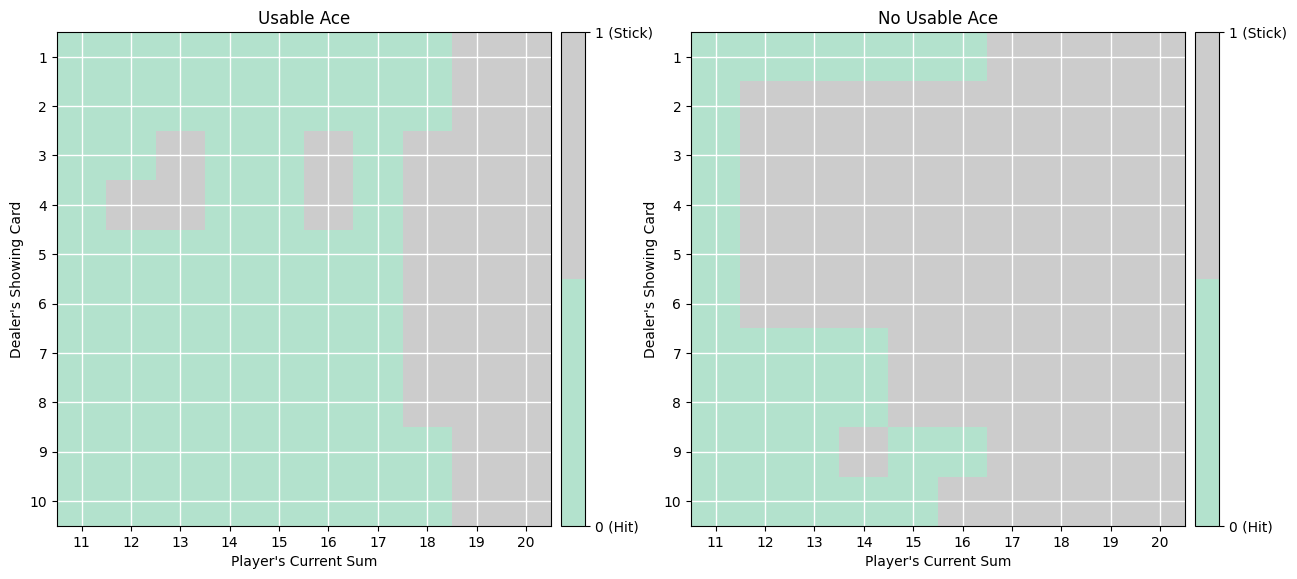

In [49]:
# QTableDictForQL keys: (player, dealer, usableAce, Standing/Hitting)

QTable = QTableDictForMC
#plot_blackjack_values(QTable)

print(QTable.items())
player_range = np.arange(11, 21)
dealer_range = np.arange(10, 0, -1)
policy = {}
for x in player_range:
  for y in dealer_range:
    # for not usuable ace
    usuable_ace = 0
    val_hitting = QTable[(x, y, usuable_ace, 1)]
    val_standing = QTable[(x, y, usuable_ace, 0)]
    should_hit = int(val_hitting > val_standing)
    policy[(x, y, usuable_ace)] = should_hit

    # for usuable ace
    usuable_ace = 1
    val_hitting = QTable[(x, y, usuable_ace, 1)]
    val_standing = QTable[(x, y, usuable_ace, 0)]
    should_hit = int(val_hitting > val_standing)
    policy[(x, y, usuable_ace)] = should_hit

plot_policy(policy)